# Capstone Project - The Battle of Neighborhoods

## Minority-owned small business relief

Prepared by: Tony Purkal

### Introduction

My final project focuses on choosing a minority-owned or minority-serving small businesses for relief from COVID-19 shutdowns and looting of communities that continue to tear down black communities in New York City. With over 200,000 COVID-19 cases in New York according to [Wikipedia](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_New_York_(state)), the most at-risk residents also live in areas prone to being food deserts and are increasingly relying on neighborhood institutions with established presence in the community for not only sustenance, but as a necessary resource for community economic vitality. Providing opportunities for others to step outside their comfort zone and explore new communities and cultures often involves sharing appealing cuisines at thriving neighborhood restaurants. This exploration will identify which neighborhoods and boroughs have the most opportunity for leveraging the unifying cultural relevance of soul food.

Specifically, this analysis will identify:

1. Which specific restaurants would produce the most impact with a community grant?

2. Where do I go in New York if I want a culturally-relevant immersive experience while patronizing a minority-owned or minority-serving establishment?

### Data

To answer these questions, we will need geolocation data about New York boroughs and neighborhoods as well as crowd-sourced data about restaurant engagement with specific communities.

To access crowd-sourced data about restaurants, their addresses will need to be converted into latitude and longitude geolocation information. To classify this data, we will also need geolocation data that defines boundaries of boroughs and neighborhoods. This data is available freely online at:
https://cocl.us/new_york_dataset

With the geolocation data paired to the restaurants in specific boroughs and neighborhoods, the Foursquare API will allow us to explore each locality and the prevalence of soul food restaurants in the community as well as crowd-sourced ratings and reviews. The Python Request library will be used to explore the API for the boroughs and neighborhoods with the most and best soul food restaurants. Information about the data from the Foursquare API can be found at:
https://developer.foursquare.com/

### Methodology

#### Overview
1. Freely available geolocation data for boroughs and neighborhoods is transformed into a Pandas dataframe.

2. Requests are submitted to Foursquare API for Soul Food restaurants in New York.

3. Requests are submitted to Foursquare API to gather details (ratings, likes, and tips).

4. Foursquare API data merged with freely available geolocation data to create a Pandas dataframe for analysis by borough or neighborhood.

5. Simple statitistical analysis is performed and visualzied with Matplotlib for insights, as well as geospatial visualization with Folium.

##### Importing dependencies

In [2]:
import pandas as pd

In [3]:
import requests

In [4]:
import folium

In [5]:
from geopy.geocoders import Nominatim

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

##### Defining an instance of the geopy geocoder to get latitude and longitude values of New York City

In [8]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

##### Defining URLs for Foursquare API GET requests for restaurants and storing in a Pandas dataframe for processing

In [9]:
def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### Defining URLs for Foursquare API GET requests for crowdsource data and storing in a Pandas dataframe for processing

In [18]:
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### Loading geolocation data for boroughs and neighborhoods and storing in a Pandas dataframe for processing

In [19]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [20]:
ny_data = get_new_york_data()

##### Exploring the number of Soul Food restaurants in each borough and neighborhood (API GET results saved to prevent limited requests)

In [21]:
ny_data.shape

(306, 4)

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
soul_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    soul_resturants=venues[venues['Category']=='Southern / Soul Food Restaurant']   
    print('(',count,'/',len(ny_data),')','Southern / Soul Food Restaurant in '+Neighborhood+', '+Borough+':'+str(len(soul_resturants)))
    print(row)
    for resturant_detail in soul_resturants.values.tolist():
        id, name , category=resturant_detail
        soul_rest_ny = soul_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [ ]:
soul_rest_ny.to_csv('soul_rest_ny_tocsv1.csv')

In [23]:
soul_rest_ny = pd.read_csv('soul_rest_ny_tocsv1.csv')

In [24]:
soul_rest_ny.shape

(12, 5)

### Results

The boroughs with the most Soul Food restaurants are Brooklyn and Queens.

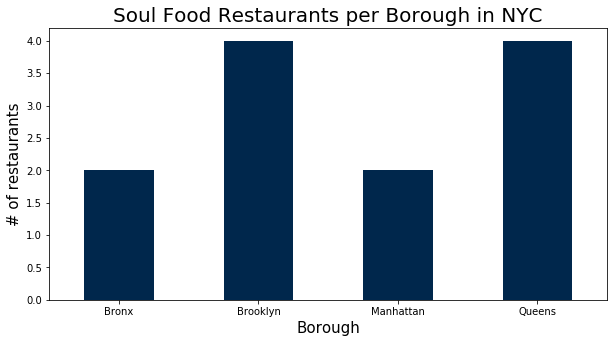

In [38]:
clr = "#00274C"
soul_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Soul Food Restaurants per Borough in NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('# of restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

The Ocean Hill neighborhood has 2 Soul Food restaurants, while all other NYC neighborhoods have 1 or less.

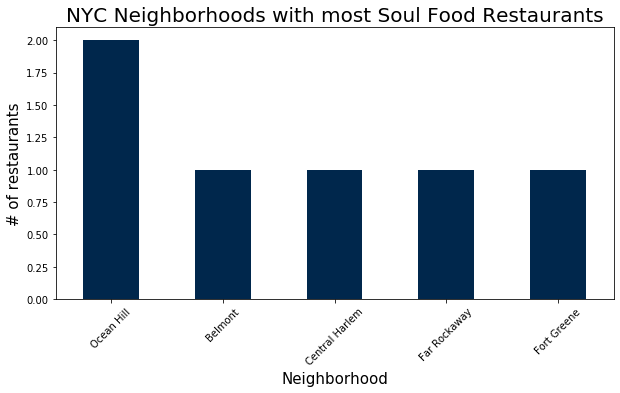

In [39]:
soul_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot.bar(figsize=(10,5), color=clr)
plt.title('NYC Neighborhoods with most Soul Food Restaurants', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('# of restaurants', fontsize=15)
plt.xticks(rotation = 45)
plt.show()

These are the 2 Soul Food restaurants in the Ocean Hill neighborhood:

In [43]:
soul_rest_ny2 = soul_rest_ny.drop(['Unnamed: 0'], axis=1)
soul_rest_ny2[soul_rest_ny['Neighborhood']=='Ocean Hill']

,Borough,Neighborhood,ID,Name
3,Brooklyn,Ocean Hill,4d55d7e5ba5b224b3a5d1314,Magic Soul Food
4,Brooklyn,Ocean Hill,4baa3e43f964a52006573ae3,Country Kitchen Soul Food Resturant


##### Exploring crowdsourced likes, ratings, and tips fo Soul Food restaurants in each borough and neighborhood (API GET results saved to prevent limited requests)

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
soul_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in soul_rest_ny2.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        id,name,likes,rating,tips=[0]*5
    soul_rest_stats_ny = soul_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [ ]:
soul_rest_stats_ny.to_csv('soul_rest_stats_ny_csv.csv')

In [46]:
soul_rest_stats_ny = pd.read_csv('soul_rest_stats_ny_csv.csv')
soul_rest_stats_ny.shape

(12, 8)

In [49]:
soul_rest_stats_ny['Likes']=soul_rest_stats_ny['Likes'].astype('float64')
soul_rest_stats_ny['Rating']=soul_rest_stats_ny['Rating'].astype('float64')
soul_rest_stats_ny['Tips']=soul_rest_stats_ny['Tips'].astype('float64')

### Discussion

Though the Ocean Hill neighborhood of Brooklyn has 2 Soul Food restaurants, the Upper West Side neighborhood of Manhattan has the Soul Food restaurant with the most likes, best ratings, and a lot of neighborhood buzz with people giving tips (Jacob's Pickles):

In [51]:
soul_rest_stats_ny.iloc[soul_rest_stats_ny['Likes'].idxmax()]

Unnamed: 0                             7
Borough                        Manhattan
Neighborhood             Upper West Side
ID              4edfd5865c5cced979ab7dd1
Name                     Jacob's Pickles
Likes                               1976
Rating                               9.1
Tips                                 653
Name: 7, dtype: object

When looking at neighborhoods, we expect the Upper West Side to shine with average ratings with popular Jacob's Pickle, and it looks like even though Ocean Hill in Brooklyn has 2 Soul Food restaurants, they aren't embraced by the community nearly as well with the Ocean Hill neighborhood coming in 6th for average Soul Food restaurant ratings:

In [54]:
ny_neighborhood_stats=soul_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,Upper West Side,9.10
3,Fort Greene,8.20
1,Central Harlem,7.20
7,Prospect Park South,6.70
4,Jamaica Hills,5.90
5,Ocean Hill,3.55
0,Belmont,0.00
2,Far Rockaway,0.00
6,Parkchester,0.00
8,Rochdale,0.00


But, Ocean Hill isn't the only neighborhood in Brooklyn and the Upper West Side isn't the only neighborhood in Manhattan: Are the other Soul Food restaurants in these neighborhoods contributing to one of the boroughs edging out the strong community support for Jacob's Pickle in Manhattan's Upper West Side? No, looks like Jacob's Pickle is putting Manhattan's Upper West Side on the Soul Food map both literally and figuratively:

In [55]:
ny_borough_stats=soul_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.150
1,Brooklyn,5.500
3,Queens,1.475
0,Bronx,0.000


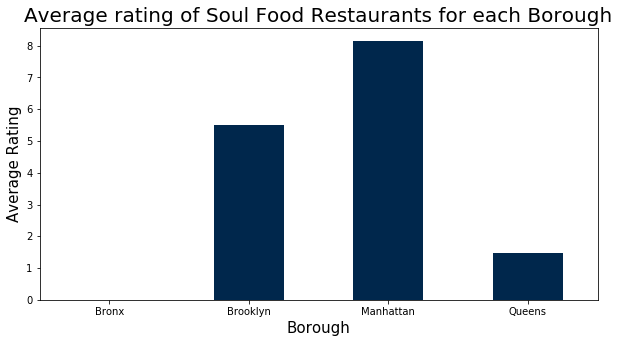

In [57]:
soul_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Soul Food Restaurants for each Borough', fontsize=20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

It appears there might be a good Soul Food restaurant in Fort Greene in Brooklyn, though:

In [58]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
3,Fort Greene,8.2
10,Upper West Side,9.1


It's Peaches Hothouse:

In [59]:
soul_rest_ny2[soul_rest_ny['Neighborhood']=='Fort Greene']

,Borough,Neighborhood,ID,Name
2,Brooklyn,Fort Greene,5bd49e5c1c675b002c9836ea,Peaches Hothouse


Peaches Houthouse must be a good Soul Food spot in the Fort Greene neighborhood of Brooklyn, with 45 likes and a 8.2 rating. Not quite the 9.1 rating of Jacob's Pickle in Manhattan, but it also has less overall likes and engagement. This is likely due to quite a difference in population and overall neighborhood engagement and spending eating out when comparing Manhattan's Upper West Side with somewhere in Brooklyn:

In [61]:
soul_rest_stats_ny.loc[soul_rest_stats_ny['Name']=='Peaches Hothouse']


,Unnamed: 0,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
2,2,Brooklyn,Fort Greene,5bd49e5c1c675b002c9836ea,Peaches Hothouse,45.0,8.2,15.0


In [62]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Fort Greene,40.688527,-73.972906,8.2
1,Manhattan,Upper West Side,40.787658,-73.977059,9.1


In [63]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
incidents = folium.map.FeatureGroup()
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

### Conlusion

Here's how to find good Soul Food: in Manhattan's Upper West Side at Jacob's Pickles or in Brooklyn's Fort Greene at Peaches Hothouse.

In [64]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
ny_map.add_child(incidents)

Manhattan has the best-rated Soul Food, followed by Brooklyn:

In [65]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10.5)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_neighborhood_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.borough',
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name='Average Rating',
    reset=True
)
ny_map

While you're sure to have a culturally-relevant immersive experience while patronizing a minority-owned or minority-serving establishment in either Brookyln's Fort Greene neighborhood or Manhattan's Upper West Side, our community grant will be awarded to Jacob's Pickles in Manhattan's Upper West Side. This restaurant has consistently engaged with the community and the community engages right back. Based on Foursquare's data and this analysis, we are confident that this community institution will make the most positive economic and cultural impact with the funds available.